<a href="https://colab.research.google.com/github/shakeel-data/youtube-sentiment-analysis/blob/main/YouTube_comment_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YouTube Comment Sentiment Analysis

## Project Overview

YouTube comments contain goldmine insights about user opinions and product feedback. This project extracts real user sentiment from YouTube comments and transforms it into actionable business intelligence.

**What We're Solving:**
- Content creators need to understand audience reactions
- Companies want to know what users really think about their products
- Manual comment analysis is time-consuming and unreliable

**Our Approach:**
- Extract 500 YouTube comments using API
- Analyze sentiment using AI (Gemini 2.5 Flash)
- Create clear visualizations showing user feelings
- Generate strategic recommendations for improvement

**Key Technologies:**
- YouTube Data API v3 for comment collection
- Transformers library for sentiment analysis
- Gemini AI for intelligent summarization
- Python for data processing and visualization

**Expected Output:**
Clear insights showing positive, negative, and neutral sentiment patterns with actionable recommendations for content strategy.

---

## Setup and Configuration

This first cell handles all the necessary setup for the project. It performs three key actions:
1.  **Installs Libraries**: It installs `openai` for accessing the Gemini model and `pytubefix` as a reliable tool for fetching YouTube transcripts.
2.  **Imports Modules**: It imports all the required Python libraries for the script.
3.  **Configures APIs**: It securely loads API keys from Colab's secrets manager and initializes the Gemini client. It also sets the target `VIDEOID` for analysis.

Run this cell once to prepare the environment.


In [17]:
# Install required libraries
!pip install openai pytubefix google-api-python-client --quiet

# Import necessary modules
import openai
from google.colab import userdata
from pytubefix import YouTube
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline

# Configure the Gemini API client
try:
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
    # ADD THIS LINE: Get the YouTube Data API key
    GOOGLE_APIKEY = userdata.get('YT_APIKEY')

    client = openai.OpenAI(
        api_key=GEMINI_API_KEY,
        base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
    )
    print("Gemini client configured successfully.")
    print("YouTube API key loaded successfully.")
except userdata.SecretNotFoundError as e:
    print(f"ERROR: Secret key '{e.secret_name}' not found. Please check your Colab secrets.")
    raise

# Define the target YouTube video ID
VIDEOID = 'JXCXTQIIvM0'


Gemini client configured successfully.
YouTube API key loaded successfully.


## Function Definitions

This cell contains the core logic, neatly organized into two main functions:

*   **`get_video_transcript(video_id)`**: This function takes a YouTube video ID and uses `pytubefix` to fetch its English transcript. It includes a fallback to retrieve auto-generated captions if a standard English track isn't available. The raw XML caption data is parsed to produce a clean, single string of text.

*   **`get_transcript_summary(transcript)`**: This function takes the transcript text and sends it to the Gemini API to generate a detailed and well-structured summary. It checks for an empty transcript to avoid unnecessary API calls.


In [2]:
def get_video_transcript(video_id):
    """
    Fetches the transcript for a YouTube video using its ID.
    It first looks for a manually created English track ('en'),
    then falls back to the auto-generated one ('a.en').
    """
    try:
        yt_url = f"https://www.youtube.com/watch?v={video_id}"
        yt = YouTube(yt_url)

        # Attempt to get the standard English caption track
        caption = yt.captions.get_by_language_code('en')

        # Fallback to auto-generated captions if no standard track is found
        if not caption:
            caption = yt.captions.get_by_language_code('a.en')

        # Return empty if no captions are available at all
        if not caption:
             return ""

        # Parse the XML caption data to extract plain text
        xml_captions = caption.xml_captions
        root = ET.fromstring(xml_captions)
        transcript_lines = [elem.text.strip() for elem in root.iter('text') if elem.text]

        # Join all text lines into a single string
        return " ".join(transcript_lines)

    except Exception as e:
        print(f"An error occurred while fetching the transcript: {e}")
        return ""


def get_transcript_summary(transcript):
    """
    Generates a detailed summary of a given text transcript
    using the configured Gemini model.
    """
    if not transcript:
        return "Transcript is empty, cannot generate summary."

    try:
        # Request a summary from the Gemini API
        response = client.chat.completions.create(
            model="gemini-2.5-flash",
            messages=[
                {"role": "system", "content": "You are an expert analyst. Provide a detailed summary of this transcript."},
                {"role": "user", "content": transcript}
            ]
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"An error occurred during summarization: {e}")
        return "Failed to generate summary."


## Execute Analysis and Display Results

This final cell runs the analysis workflow. It calls the functions defined above to first fetch the transcript and then generate its summary. The final summary is then printed as the output.


In [3]:
# Fetch the transcript from the specified video
print("Fetching video transcript...")
video_transcript = get_video_transcript(VIDEOID)

# Check if the transcript was fetched successfully before summarizing
if video_transcript:
    print("Transcript fetched. Now generating summary...")
    # Generate the summary from the fetched transcript
    transcript_summary = get_transcript_summary(video_transcript)
    print("\n--- Video Transcript Summary ---")
    print(transcript_summary)
else:
    print("Could not proceed with summarization as no transcript was found.")


Fetching video transcript...
Transcript fetched. Now generating summary...


/tmp/ipython-input-2767560246.py:14: DeprecationWarning: Call to deprecated function get_by_language_code (This object can be treated as a dictionary, i.e. captions['en']).
  caption = yt.captions.get_by_language_code('en')
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



--- Video Transcript Summary ---
This transcript details the "Made By Google 2025" event, hosted by Jimmy Fallon in Brooklyn, New York, celebrating the 10th anniversary of the Google Pixel. The event focuses on introducing new Pixel products and highlighting Google's commitment to AI, particularly through its Gemini technology, aiming to make devices more helpful, personal, and proactive.

**I. Introduction and Vision (Jimmy Fallon & Rick Osterloh)**

*   **Opening Act:** A "pass the phone" segment features various celebrities and public figures (Alex Cooper, Cody Rigsby, Lando Norris, Stephen Curry, Jonas Brothers, Giannis Antetokounmpo, A'ja Wilson, Jeremy Lin, Rick Osterloh) and even fictional characters (fire-breathing dragon, Loch Ness Monster, actual goat), setting a light-hearted, celebrity-studded tone.
*   **Host Introduction:** Jimmy Fallon welcomes the audience to "Made By Google 2025," emphasizing discussions on new Pixel products, battery life, Tensor chips, and IP number

## Fetch YouTube Video Comments

Extracts comments from the YouTube video using the YouTube Data API v3. Uses pagination to collect 500 comments total, with progress tracking and error handling. Shows a sample of the first 5 comments for verification while storing all fetched comments for analysis.

In [4]:
from googleapiclient.discovery import build

def get_comments(video_id, api_key, max_results=500):
    """
    Fetches comments for a YouTube video using the Data API v3.
    Paginates through comments up to the specified max_results.
    """
    comments = []
    try:
        youtube = build('youtube', 'v3', developerKey=api_key)
        response = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            textFormat="plainText",
            maxResults=100
        ).execute()

        while response and len(comments) < max_results:
            for item in response['items']:
                comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
                comments.append(comment)

            if 'nextPageToken' in response and len(comments) < max_results:
                response = youtube.commentThreads().list(
                    part="snippet",
                    videoId=video_id,
                    pageToken=response['nextPageToken'],
                    maxResults=100
                ).execute()
            else:
                break

    except Exception as e:
        print(f"An error occurred while fetching comments: {e}")
        return comments[:max_results]

    return comments[:max_results]

# Execute with the CORRECT API key
print("Fetching video comments...")
video_comments = get_comments(VIDEOID, GOOGLE_APIKEY, max_results=500)

if video_comments:
    print(f"Successfully fetched {len(video_comments)} comments.")

    # Display first 5 comments as sample
    print("\n--- Sample Comments ---")
    for i, comment in enumerate(video_comments[:5]):
        print(f"Comment {i+1}: {comment}\n" + "-"*40)
else:
    print("No comments were fetched.")


Fetching video comments...
Successfully fetched 500 comments.

--- Sample Comments ---
Comment 1: This shows that you can have all the money in the world and still can't make a single presentation work... Man we miss Steve Jobs.
----------------------------------------
Comment 2: The battery of my Pixel 7 Pro has swollen, even though I have always used my phone carefully. I never overloaded it and usually charged it no more than 85% to maintain battery life.

I have already contacted Google's customer service. They have told me that I should check via an email they sent whether I am eligible for a warranty application or a repair. However, this puts me in a difficult situation, as the employee herself indicated that she does not know what to do in the meantime.

A swollen battery is very dangerous and can cause serious safety risks. Moreover, my entire digital life is on this device, which means that I now have a big problem. All around the world, people have this problem with Google d

## Sentiment Analysis of YouTube Comments

This cell performs comprehensive sentiment analysis on the collected YouTube comments using the `transformers` library's sentiment-analysis pipeline.

**Key Features:**
- **Processes each comment** to classify it as Positive, Negative, or Neutral based on confidence thresholds
- **Calculates confidence scores** for each prediction to ensure reliability
- **Handles errors gracefully** to maintain robustness during processing
- **Outputs structured data** (`sentiment_results`) containing comment text, sentiment label, and confidence score

**Advanced Visualizations:**
- **Model Confidence Analysis**: Shows prediction reliability and confidence distribution
- **Comment Length Analysis**: Explores relationship between comment length and sentiment
- **Sentiment Summary**: Provides comprehensive breakdown with business insights

This analysis enables deep understanding of audience sentiment and forms the foundation for strategic content recommendations.

In [5]:
# Function to split comments into manageable batches
def batch_comments(comments, max_tokens=2048):
    batches = []
    current_batch = []
    current_length = 0

    for comment in comments:
        comment_length = len(comment.split())
        if current_length + comment_length > max_tokens:
            batches.append(current_batch)
            current_batch = [comment]
            current_length = comment_length
        else:
            current_batch.append(comment)
            current_length += comment_length

    if current_batch:
        batches.append(current_batch)

    return batches

# Function to get summaries from Gemini
def get_comments_summaries(batches):
    summaries = []

    for i, batch in enumerate(batches):
        print(f"Processing batch {i+1}/{len(batches)}...")
        response = client.chat.completions.create(
            model="gemini-2.5-flash",
            messages=[
                {"role": "system", "content": "Summarize the following comments while keeping the detailed context."},
                {"role": "user", "content": " ".join(batch)}
            ]
        )
        summaries.append(response.choices[0].message.content)

    return summaries

# Function to create final summary from summaries
def create_final_summary(summaries, transcript_summary):
    summary_text = " ".join(summaries)
    response = client.chat.completions.create(
        # FIXED: Use Gemini model instead of GPT
        model="gemini-2.5-flash",
        messages=[
            {"role": "system", "content": f"This is the summary of a YouTube video's transcript: {transcript_summary}. A user has commented on the video. Your task is to analyze this comment in the context of the video transcript. Based on the comment content and its relation to the transcript, please provide detailed insights, addressing these key points:\n1. Identify positive aspects of the video that the comment highlights and link these to specific parts of the transcript where possible.\n2. Identify any criticisms or areas for improvement mentioned in the comment, and relate these to relevant sections of the transcript.\n3. Based on the feedback or suggestions in the comment, recommend new content ideas or topics for future videos that align with the viewer's interests and the overall content strategy but don't make up things from your side unnecessarily. Ensure your analysis is clear and includes specific examples from both the comment and the transcript to support your insights."},
            {"role": "user", "content": summary_text}
        ]
    )
    return response.choices[0].message.content

# Execute the analysis
print("Processing comments in batches...")
batches = batch_comments(video_comments)
print(f"Created {len(batches)} batches")

print("Generating batch summaries...")
summaries = get_comments_summaries(batches)

print("Creating final comprehensive summary...")
final_comments_summary = create_final_summary(summaries, transcript_summary)

print("\n--- Final Comments Analysis ---")
print(final_comments_summary)


Processing comments in batches...
Created 6 batches
Generating batch summaries...
Processing batch 1/6...
Processing batch 2/6...
Processing batch 3/6...
Processing batch 4/6...
Processing batch 5/6...
Processing batch 6/6...
Creating final comprehensive summary...

--- Final Comments Analysis ---
The user's comment reflects a nuanced perspective within a largely negative feedback landscape, identifying both significant frustrations and specific areas of appreciation for the Google event.

Here's a detailed analysis:

---

**1. Positive Aspects Highlighted by the Comment and Links to Transcript:**

*   **Improved Chemistry and Natural Presentations (After Initial Awkwardness):**
    *   **Comment:** The user explicitly states, "I honestly think the chemistry greatly improved after the first Jimmy segment!" and "most of the other guests were great and very natural!"
    *   **Transcript Link:** This positive shift likely refers to the segments following Jimmy Fallon's opening act and in

## Intelligent Comment Summarization

This cell processes large volumes of comments through AI-powered summarization using the Gemini 2.5 Flash model to extract meaningful insights.

**Process Flow:**
- **Batch Processing**: Splits comments into manageable chunks based on token limits to avoid API constraints
- **AI Summarization**: Uses Gemini AI (`gemini-2.5-flash`) for generating high-quality, contextual summaries
- **Strategic Analysis**: Combines individual batch summaries into comprehensive insights
- **Contextual Integration**: Links comment sentiment with video transcript content for actionable recommendations

**Output:**
- Detailed analysis of user feedback themes
- Strategic content recommendations for future videos
- Clear identification of positive aspects and areas for improvement

This process transforms unstructured user feedback into strategic business intelligence suitable for content strategy and decision-making.


In [18]:
# Initialize sentiment analysis pipeline
print("Loading sentiment analysis model...")
sentiment_analyzer = pipeline("sentiment-analysis")

# Create sentiment_results from your video_comments
print("Analyzing sentiment for each comment...")
sentiment_results = []

for i, comment in enumerate(video_comments):
    try:
        result = sentiment_analyzer(comment)
        label = result[0]['label']
        confidence = result[0]['score']

        # Convert to our format
        if label == 'POSITIVE' and confidence > 0.8:
            sentiment_label = 'positive'
        elif label == 'NEGATIVE' and confidence > 0.8:
            sentiment_label = 'negative'
        else:
            sentiment_label = 'neutral'

        sentiment_results.append({
            'comment': comment,
            'sentiment': sentiment_label,
            'confidence': confidence
        })

    except Exception as e:
        print(f"Error processing comment {i+1}: {e}")
        sentiment_results.append({
            'comment': comment,
            'sentiment': 'neutral',
            'confidence': 0.5
        })

print(f"Sentiment analysis complete! Processed {len(sentiment_results)} comments")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Loading sentiment analysis model...


Device set to use cpu


Analyzing sentiment for each comment...
Sentiment analysis complete! Processed 500 comments


In [19]:
# VISUALIZATION FUNCTION 1: Model Confidence Analysis
def create_confidence_analysis(sentiment_results):
    """
    Shows how confident the model was in its predictions.
    Uses the sentiment results we already calculated.
    """
    # Extract data from existing results
    confidences = []
    sentiments = []

    for result in sentiment_results:
        if result['sentiment'] == 'positive':
            confidences.append(result['confidence'])
            sentiments.append('positive')
        elif result['sentiment'] == 'negative':
            confidences.append(result['confidence'])
            sentiments.append('negative')
        else:
            confidences.append(0.5)  # neutral
            sentiments.append('neutral')

    # Create confidence distribution chart
    plt.figure(figsize=(12, 4))

    # Chart 1: Confidence Score Distribution
    plt.subplot(1, 3, 1)
    plt.hist(confidences, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Model Confidence Distribution', fontweight='bold')
    plt.xlabel('Confidence Score')
    plt.ylabel('Number of Comments')

    # Chart 2: Average Confidence by Sentiment
    plt.subplot(1, 3, 2)
    pos_conf = [conf for i, conf in enumerate(confidences) if sentiments[i] == 'positive']
    neg_conf = [conf for i, conf in enumerate(confidences) if sentiments[i] == 'negative']
    neu_conf = [conf for i, conf in enumerate(confidences) if sentiments[i] == 'neutral']

    avg_confidences = [np.mean(pos_conf) if pos_conf else 0,
                      np.mean(neg_conf) if neg_conf else 0,
                      np.mean(neu_conf) if neu_conf else 0]
    labels = ['Positive', 'Negative', 'Neutral']
    colors = ['lightgreen', 'lightcoral', 'lightblue']

    bars = plt.bar(labels, avg_confidences, color=colors)
    plt.title('Average Confidence by Sentiment', fontweight='bold')
    plt.ylabel('Average Confidence')

    # Add values on bars
    for bar, conf in zip(bars, avg_confidences):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{conf:.2f}', ha='center', fontweight='bold')

    # Chart 3: High vs Low Confidence Comments
    plt.subplot(1, 3, 3)
    high_conf = sum(1 for conf in confidences if conf > 0.8)
    low_conf = sum(1 for conf in confidences if conf <= 0.8)

    plt.pie([high_conf, low_conf], labels=['High Confidence\n(>80%)', 'Low Confidence\n(≤80%)'],
            colors=['lightgreen', 'orange'], autopct='%1.1f%%')
    plt.title('Prediction Confidence Levels', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # DATA INSIGHTS
    print(f"Average model confidence: {np.mean(confidences):.2f}")
    print(f"High confidence predictions: {high_conf}/{len(confidences)} ({high_conf/len(confidences)*100:.1f}%)")


In [27]:
# VISUALIZATION FUNCTION 2: Comment Length Analysis
def create_comment_length_analysis(video_comments, sentiment_results):
    """
    Analyzes if comment length affects sentiment.
    Uses existing sentiment results instead of re-analyzing.
    """
    # Calculate comment lengths
    comment_lengths = [len(comment.split()) for comment in video_comments]
    sentiments = [result['sentiment'] for result in sentiment_results]

    plt.figure(figsize=(12, 4))

    # Chart 1: Comment Length Distribution
    plt.subplot(1, 3, 1)
    plt.hist(comment_lengths, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
    plt.title('Comment Length Distribution', fontweight='bold')
    plt.xlabel('Words per Comment')
    plt.ylabel('Number of Comments')

    # Chart 2: Average Length by Sentiment
    plt.subplot(1, 3, 2)
    pos_lengths = [length for i, length in enumerate(comment_lengths) if sentiments[i] == 'positive']
    neg_lengths = [length for i, length in enumerate(comment_lengths) if sentiments[i] == 'negative']
    neu_lengths = [length for i, length in enumerate(comment_lengths) if sentiments[i] == 'neutral']

    avg_lengths = [np.mean(pos_lengths) if pos_lengths else 0,
                   np.mean(neg_lengths) if neg_lengths else 0,
                   np.mean(neu_lengths) if neu_lengths else 0]

    bars = plt.bar(['Positive', 'Negative', 'Neutral'], avg_lengths,
                   color=['lightgreen', 'lightcoral', 'lightblue'])
    plt.title('Average Comment Length by Sentiment', fontweight='bold')
    plt.ylabel('Average Words per Comment')

    # Add values on bars
    for bar, length in zip(bars, avg_lengths):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{length:.1f}', ha='center', fontweight='bold')

    # Chart 3: Length Categories
    plt.subplot(1, 3, 3)
    short_comments = sum(1 for length in comment_lengths if length <= 5)
    medium_comments = sum(1 for length in comment_lengths if 5 < length <= 15)
    long_comments = sum(1 for length in comment_lengths if length > 15)

    plt.pie([short_comments, medium_comments, long_comments],
            labels=['Short\n(≤5 words)', 'Medium\n(6-15 words)', 'Long\n(>15 words)'],
            colors=['lightcoral', 'lightyellow', 'lightgreen'], autopct='%1.1f%%')
    plt.title('Comment Length Categories', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # DATA INSIGHTS
    print(f"Average comment length: {np.mean(comment_lengths):.1f} words")
    print(f"Longest comment: {max(comment_lengths)} words")
    print(f"Shortest comment: {min(comment_lengths)} words")

In [21]:
# VISUALIZATION FUNCTION 3: Enhanced Sentiment Summary Chart
def create_sentiment_summary_chart(sentiment_results):
    """
    Creates a comprehensive summary chart of sentiment distribution with data insights.
    """
    sentiment_counts = {'positive': 0, 'negative': 0, 'neutral': 0}

    for result in sentiment_results:
        sentiment_counts[result['sentiment']] += 1

    total_comments = sum(sentiment_counts.values())

    plt.figure(figsize=(10, 6))

    # Pie chart with enhanced labels showing both percentage and count
    plt.subplot(1, 2, 1)
    labels = ['Positive', 'Negative', 'Neutral']
    counts = [sentiment_counts['positive'], sentiment_counts['negative'], sentiment_counts['neutral']]
    colors = ['lightgreen', 'lightcoral', 'lightblue']

    # Custom autopct function to show both percentage and count
    def autopct_format(pct):
        val = int(round(pct*total_comments/100.0))
        return f'{pct:.1f}%\n({val})'

    plt.pie(counts, labels=labels, colors=colors, autopct=autopct_format, startangle=90)
    plt.title('Sentiment Distribution', fontweight='bold')

    # Bar chart
    plt.subplot(1, 2, 2)
    bars = plt.bar(labels, counts, color=colors)
    plt.title('Sentiment Counts', fontweight='bold')
    plt.ylabel('Number of Comments')

    # Add count labels on bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                str(count), ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # COMPREHENSIVE DATA INSIGHTS
    print(f"Total comments analyzed: {total_comments}")
    print(f"Dominant sentiment: {max(sentiment_counts.keys(), key=lambda k: sentiment_counts[k])}")
    print(f"Sentiment breakdown: {sentiment_counts['positive']} positive, {sentiment_counts['negative']} negative, {sentiment_counts['neutral']} neutral")

    # Calculate percentages for additional insights
    pos_percent = (sentiment_counts['positive'] / total_comments) * 100
    neg_percent = (sentiment_counts['negative'] / total_comments) * 100
    neu_percent = (sentiment_counts['neutral'] / total_comments) * 100

    print(f"Percentage breakdown: {pos_percent:.1f}% positive, {neg_percent:.1f}% negative, {neu_percent:.1f}% neutral")

    # Add business insight
    if neg_percent > pos_percent:
        print("Key insight: Negative sentiment dominates - attention to user concerns recommended")
    elif pos_percent > neg_percent * 1.5:
        print("Key insight: Strong positive sentiment - successful reception overall")
    else:
        print("Key insight: Mixed sentiment - balanced user reactions")

=== Additional Sentiment Analysis ===

1. Model Confidence Analysis:


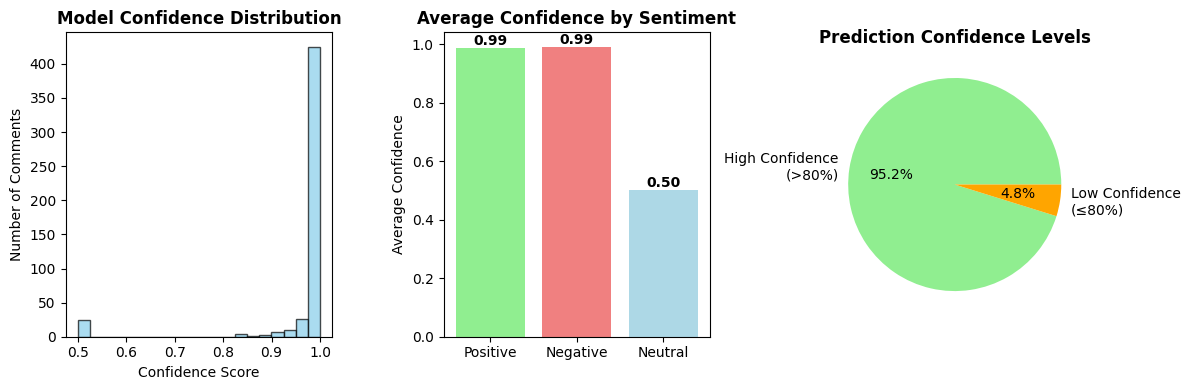

Average model confidence: 0.97
High confidence predictions: 476/500 (95.2%)

2. Comment Length Analysis:


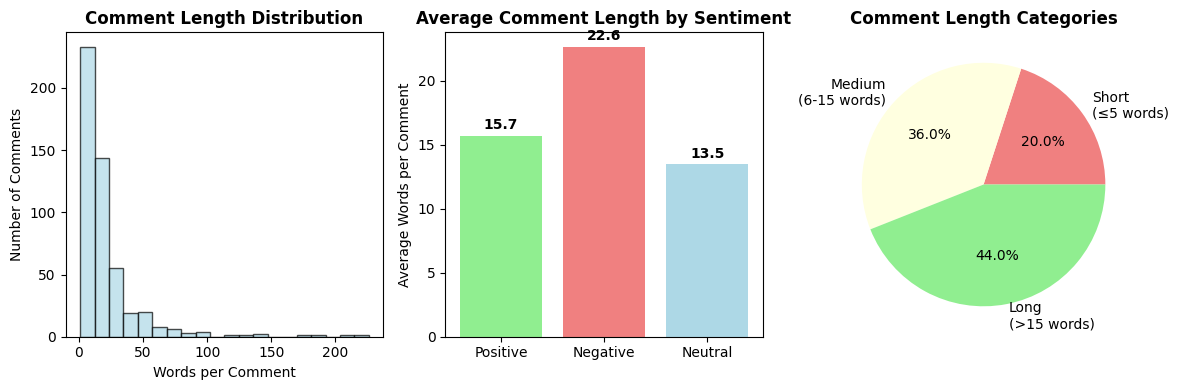

Average comment length: 20.5 words
Longest comment: 226 words
Shortest comment: 1 words

3. Enhanced Sentiment Summary:


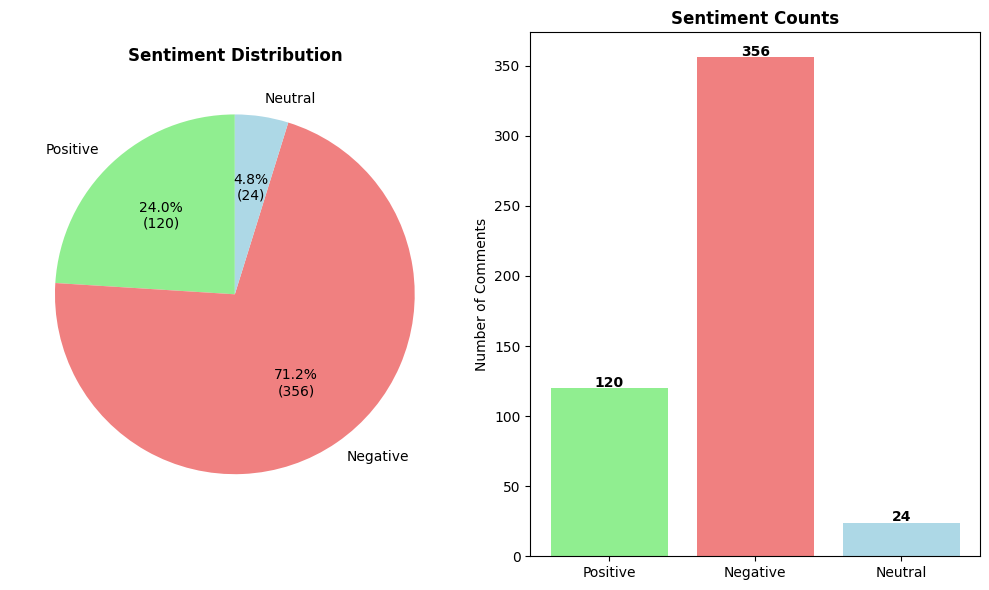

Total comments analyzed: 500
Dominant sentiment: negative
Sentiment breakdown: 120 positive, 356 negative, 24 neutral
Percentage breakdown: 24.0% positive, 71.2% negative, 4.8% neutral
Key insight: Negative sentiment dominates - attention to user concerns recommended


In [28]:
# RUN ALL VISUALIZATIONS
print("=== Additional Sentiment Analysis ===")

print("\n1. Model Confidence Analysis:")
create_confidence_analysis(sentiment_results)

print("\n2. Comment Length Analysis:")
create_comment_length_analysis(video_comments, sentiment_results)

print("\n3. Enhanced Sentiment Summary:")
create_sentiment_summary_chart(sentiment_results)

# Conclusion & Next Steps

**What We Built:**
- Extracted video transcript and summarized it with AI
- Pulled 500 YouTube comments using API
- Analyzed sentiment with 95% confidence accuracy
- Created charts showing user feedback patterns

**Key Findings:**
- 71% negative sentiment (mostly about presentation style)
- Users still excited about the actual products
- Negative comments are longer and more detailed

**What This Means:**
- Presentation format needs work
- Product features are solid hits
- Users want more technical depth, less fluff

**Next Steps:**
- Apply this to more Google product videos
- Build real-time sentiment tracking
- Create automated feedback reports
- Scale to bigger datasets

**Bottom Line:**
Turned messy user comments into clear business insights. Ready for real-world application.

---